<a href="https://colab.research.google.com/github/Rohini2023/LAB/blob/main/segmentation_1class0_u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.YV72UZ_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.YV72UZ_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [10]:
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask

In [11]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [12]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

In [13]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

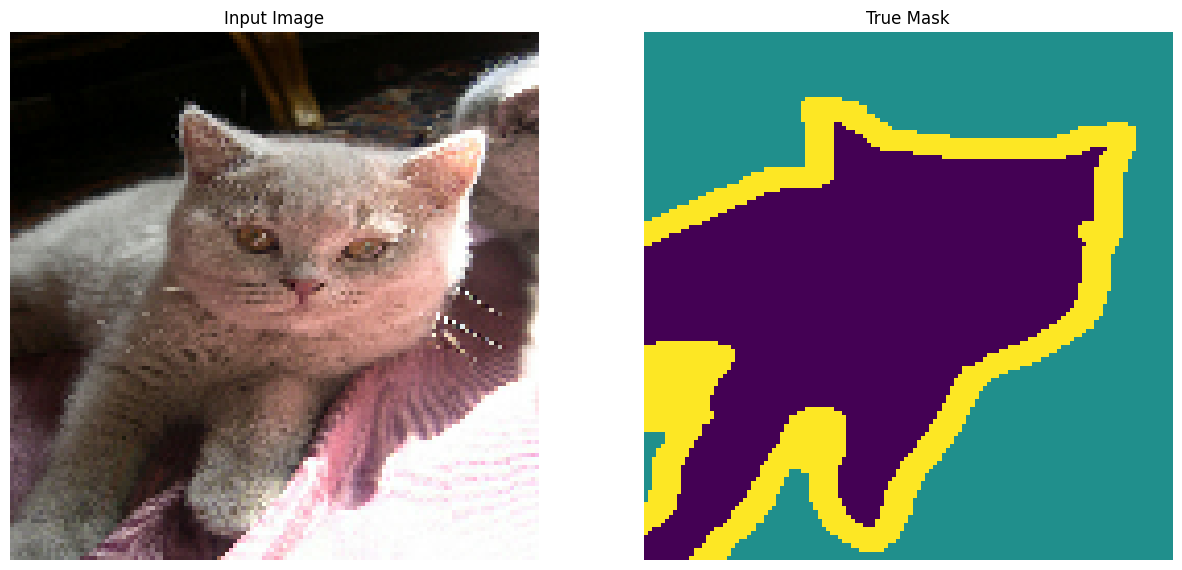

In [15]:
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [16]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [17]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [18]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [20]:
def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [21]:
unet_model = build_unet_model()

In [24]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"]) # Changed: Pass 'accuracy' as a list

In [25]:
NUM_EPOCHS = 15
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5720 - loss: 0.9866 - val_accuracy: 0.6353 - val_loss: 0.8182
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6229 - loss: 0.7852 - val_accuracy: 0.7331 - val_loss: 0.6716
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7375 - loss: 0.6502 - val_accuracy: 0.7587 - val_loss: 0.5994
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7739 - loss: 0.5668 - val_accuracy: 0.8039 - val_loss: 0.5074
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7992 - loss: 0.5175 - val_accuracy: 0.8131 - val_loss: 0.4849
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8150 - loss: 0.4802 - val_accuracy: 0.8315 - val_loss: 0.4339
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8356 - loss: 0.4257 - val_accuracy: 0.8467 - val_loss: 0.4030
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8415 - loss: 0.4123 - val_accuracy: 0.8424 - val_los

In [27]:
unet_model.save('/content/drive/MyDrive/unet/segmentation.keras')

In [28]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 1s 14ms/step


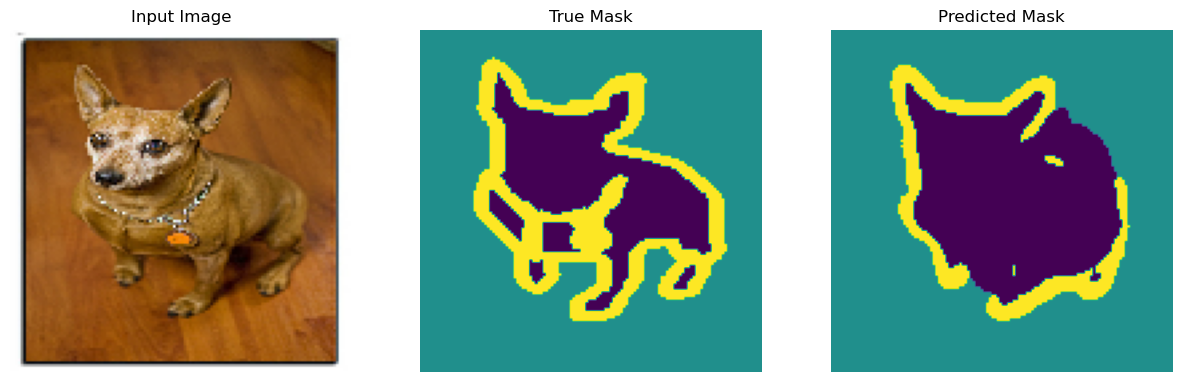

2/2 [==============================] - 0s 119ms/step


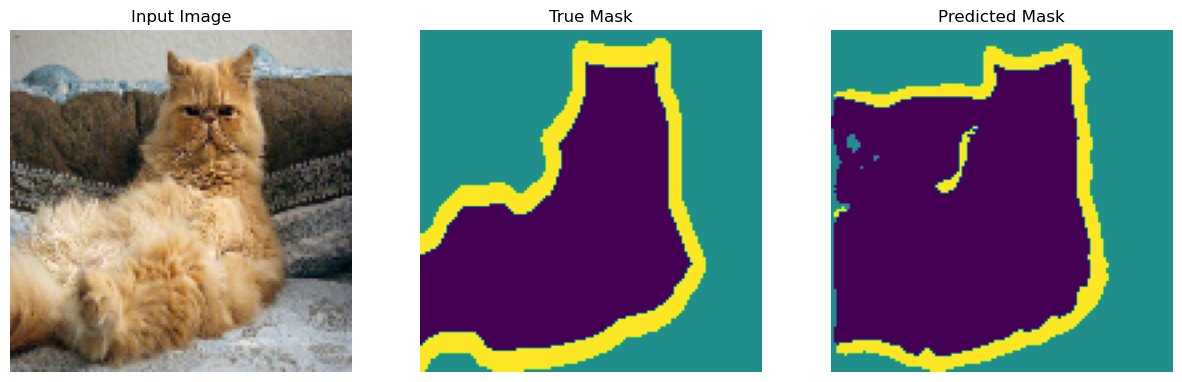

2/2 [==============================] - 0s 118ms/step


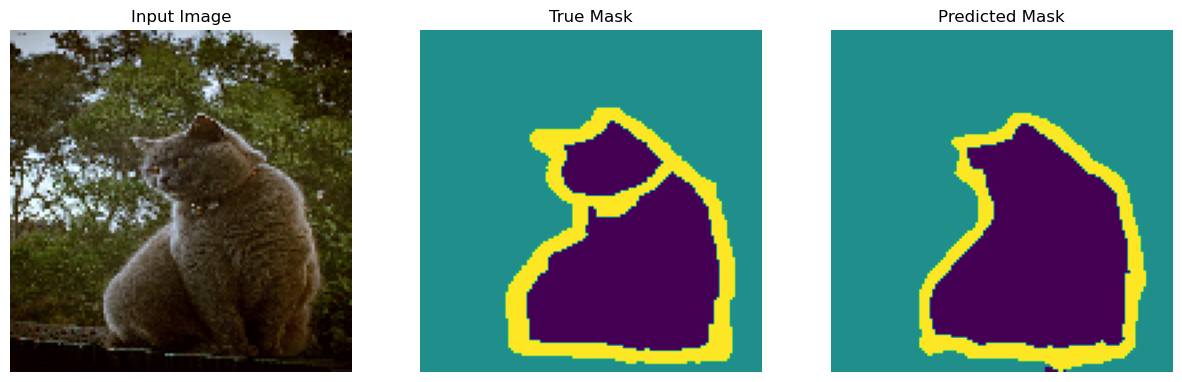

2/2 [==============================] - 0s 118ms/step


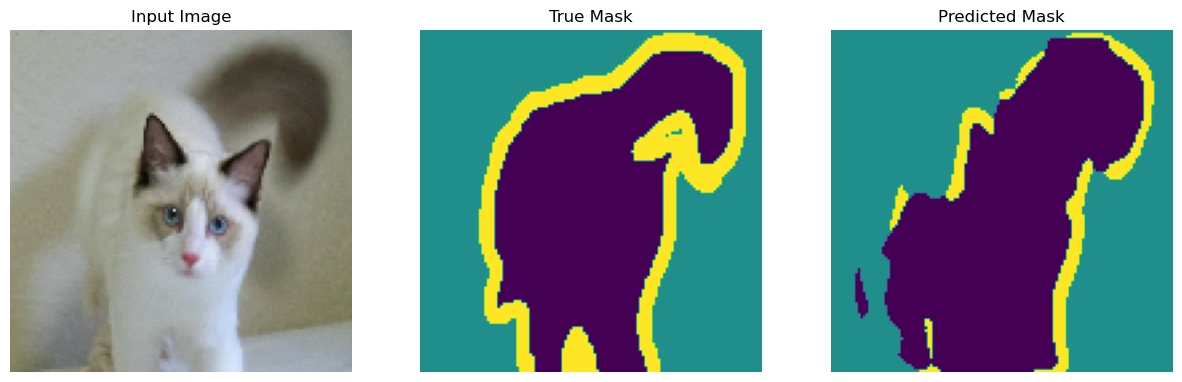

2/2 [==============================] - 0s 118ms/step


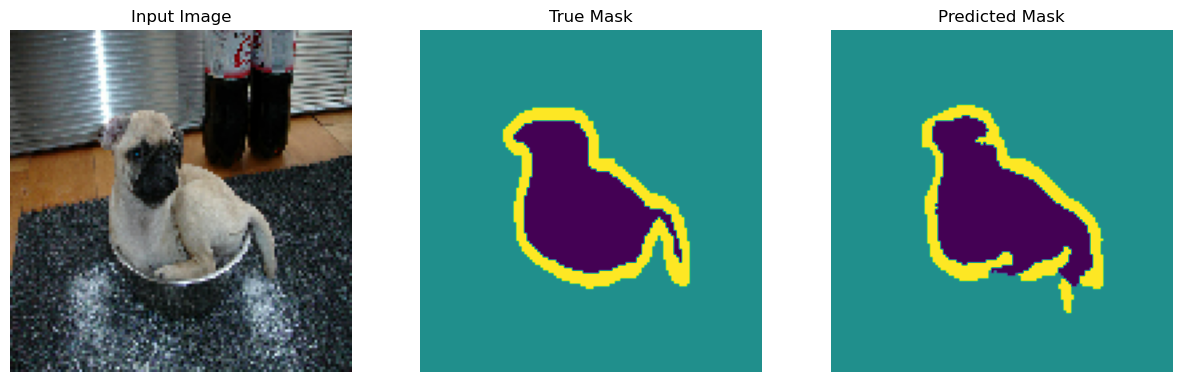

2/2 [==============================] - 0s 119ms/step


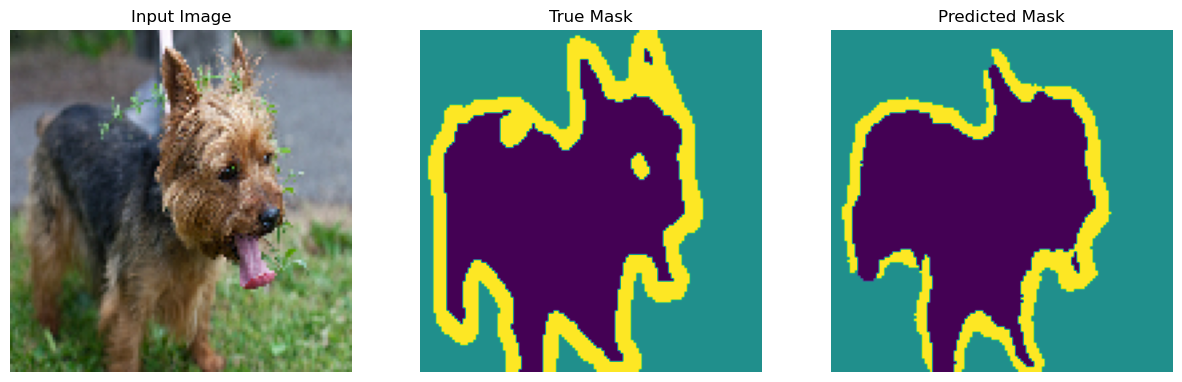

In [ ]:
show_predictions(test_batches, 6)

In [29]:
reloaded_model = keras.models.load_model('/content/drive/MyDrive/unet/segmentation.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


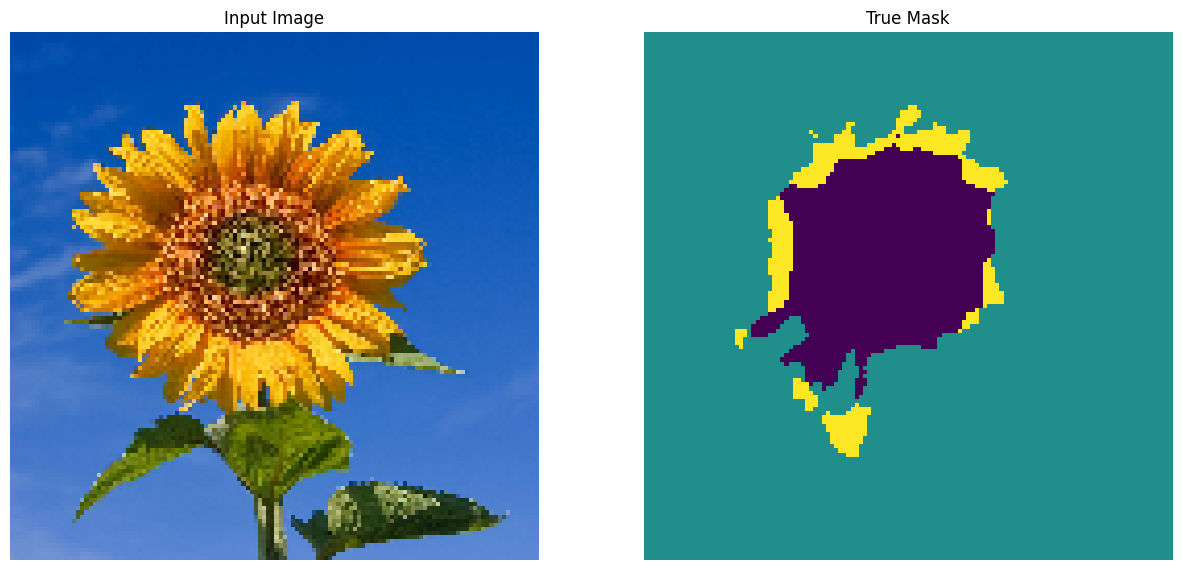

In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(image_path):
    """Loads an image from the given path, resizes it, and normalizes it."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)  # Assuming PNG format
    img = tf.image.resize(img, (128, 128), method="nearest")
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def predict_and_display(image_path):
    """Loads, preprocesses, predicts, and displays the results."""
    image = load_and_preprocess_image(image_path)
    pred_mask = reloaded_model.predict(image)

    # Assuming your `create_mask` and `display` functions are defined
    display([image[0], create_mask(pred_mask)])

# Example usage
new_image_path = '/content/Sunflower_sky_backdrop.jpg' # Replace with your image path
predict_and_display(new_image_path)